In [15]:
# HIDDEN
using CSV
using DataFrames
using MLJ
using Statistics
using StatsPlots
Base.displaysize() = (5, 80)

## Hypothesis Testing and Confidence Intervals

In this section, we provide a brief review of hypothesis testing using the bootstrap and permutation tests. We assume familiarity with this topic since it is covered at length in Computational and Inferential Thinking, the textbook for Data 8. For a more thorough explanation of the concepts explained here, see [Chapter 11](https://www.inferentialthinking.com/chapters/11/Testing_Hypotheses), [Chapter 12](https://www.inferentialthinking.com/chapters/12/Comparing_Two_Samples), and [Chapter 13](https://www.inferentialthinking.com/chapters/13/Estimation) of Computational and Inferential Thinking.

## Hypothesis Tests

When applying data science techniques to different domains, we are often faced with questions about the world. For example, does drinking coffee cause sleep deprivation? Do autonomous vehicles crash more often then non-autonomous vehicles? Does drug X help treat pneumonia? To help answer these questions, we use hypothesis tests to make informed conclusions based on observed evidence/data.

Since data collection is often an imprecise process, we are often unsure whether the patterns in our dataset are due to noise or real phenomena. Hypothesis testing helps us determine whether a pattern could have happened because of random fluctuations in our data collection.

To explore hypothesis testing, we start with an example. The table `baby` contains information on baby weights at birth. It records the baby's birth weight in ounces and whether or not the mother smoked during pregnancy for 1174 babies.

In [35]:
# HIDDEN
baby = select(CSV.read("baby.csv"), [Symbol("Birth Weight"), Symbol("Maternal Smoker")])
rename!(baby, [:Birth_Weight, :Maternal_Smoker])
baby[!, :Maternal_Smoker] = baby.Maternal_Smoker .== "True"
baby

,Birth_Weight,Maternal_Smoker
,Int64,Bool
1,120,0
2,113,0
3,128,1
4,108,1
5,136,0
⋮,⋮,⋮


### Design

We would like to see whether maternal smoking was associated with birth weight.  To set up our hypothesis test, we can represent the two views of the world using the following null and alternative hypotheses:

**Null hypothesis:** In the population, the distribution of birth weights of babies is the same for mothers who don't smoke as for mothers who do. The difference in the sample is due to chance.

**Alternative hypothesis:** In the population, the babies of the mothers who smoke have a lower birth weight, on average, than the babies of the non-smokers.

Our ultimate goal is to make a decision between these two data generation models. One important point to notice is that we construct our hypotheses about the *parameters* of the data generation model rather than the outcome of the experiment. For example, we should not construct a null hypothesis such as "The birth weights of smoking mothers will be equal to the birth weights of nonsmoking mothers", since there is natural variability in the outcome of this process.

The null hypothesis emphasizes that if the data look different from what the null hypothesis predicts, the difference is due to nothing but chance. Informally, the alternative hypothesis says that the observed difference is "real."

We should take a closer look at the structure of our alternative hypothesis. In our current set up, notice that we would reject the null hypothesis if the birth weights of babies of the mothers who smoke are significantly lower than the birth weights of the babies of the mothers who do not smoke. In other words, the alternative hypothesis encompasses/supports one side of the distribution. We call this a **one-sided** alternative hypothesis. In general, we would only want to use this type of alternative hypothesis if we have a good reason to believe that it is impossible to see babies of the mothers who smoke have a higher birth weight, on average.

To visualize the data, we've plotted histograms of the baby weights for babies born to maternal smokers and non-smokers.

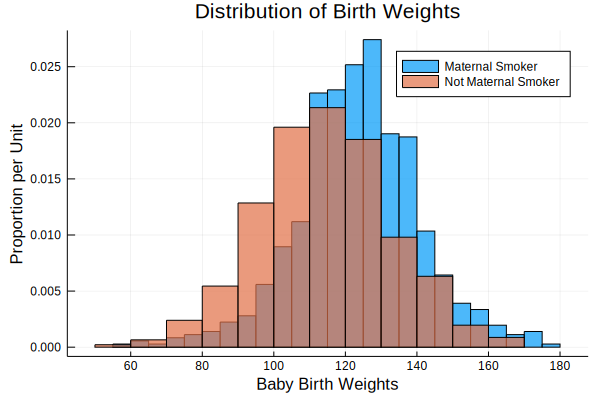

In [36]:
# HIDDEN
@df baby histogram(:Birth_Weight, group=:Maternal_Smoker, fillalpha=0.7, normalize=:pdf, 
    label=["Maternal Smoker", "Not Maternal Smoker"])
title!("Distribution of Birth Weights")
xlabel!("Baby Birth Weights")
ylabel!("Proportion per Unit")

The weights of the babies of the mothers who smoked seem lower on average than the weights of the babies of the non-smokers. Could this difference likely have occurred due to random variation? We can try to answer this question using a hypothesis test.

To perform a hypothesis test, we assume a particular model for generating the data; then, we ask ourselves, what is the chance we would see an outcome as extreme as the one that we observed? Intuitively, if the chance of seeing the outcome we observed is very small, the model that we assumed may not be the appropriate model. 

In particular, we assume that the null hypothesis and its probability model, the **null model**, is true. In other words, we assume that the null hypothesis is true and focus on what the value of the statistic would be under under the null hypothesis. This chance model says that there is no underlying difference; the distributions in the samples are different just due to chance.

### Test Statistic

In our example, we would assume that maternal smoking has no effect on baby weight (where any observed difference is due to chance). In order to choose between our hypotheses, we will use the difference between the two group means as our **test statistic**.
Formally, our test statistic is

$$\mu_{\text{smoking}} - \mu_{\text{non-smoking}}$$

so that small values (that is, large negative values) of this statistic will favor the alternative hypothesis. Let's calculate the observed value of test statistic:


In [40]:
nonsmoker = baby[baby.Maternal_Smoker .== false, :Birth_Weight]
smoker = baby[baby.Maternal_Smoker .== true, :Birth_Weight]
observed_difference = mean(smoker) - mean(nonsmoker)

-9.266142572024918

If there were really no difference between the two distributions in the underlying population, then whether each mother was a maternal smoker or not should not affect the average birth weight. In other words, the label True or False with respect to maternal smoking should make no difference to the average.

Therefore, in order to simulate the test statistic under the null hypothesis, we can shuffle all the birth weights randomly among the mothers. We conduct this random permutation below.

In [51]:
using Random

"""Adds a column to retain original row index and returns a shuffled copy of a DataFrame"""
function shuffle_df(dataframe)
    df = select(dataframe, :)
    df[!, :shuffled] = collect(1:nrows(dataframe))
    return df[shuffle(1:nrows(df)), :]
end;

In [52]:
baby_shuffled = shuffle_df(baby)

,Birth_Weight,Maternal_Smoker,shuffled
,Int64,Bool,Int64
1,127,1,335
2,122,0,30
3,96,0,169
4,131,1,634
5,126,0,728
⋮,⋮,⋮,⋮


### Conducting a Permutation Test

Tests based on random permutations of the data are called **permutation tests**. In the cell below, we will simulate our test statistic many times and collect the differences in an array. 

In [56]:
differences = []

repetitions = 5000
for i in 1:5000
    baby_shuffled = shuffle_df(baby)
    nonsmoker = baby[baby_shuffled.Maternal_Smoker .== false, :Birth_Weight]
    smoker = baby[baby_shuffled.Maternal_Smoker .== true, :Birth_Weight]
    simulated_difference = mean(smoker) - mean(nonsmoker)

    push!(differences, simulated_difference)
end

We plot a histogram of the simulated difference in means below:

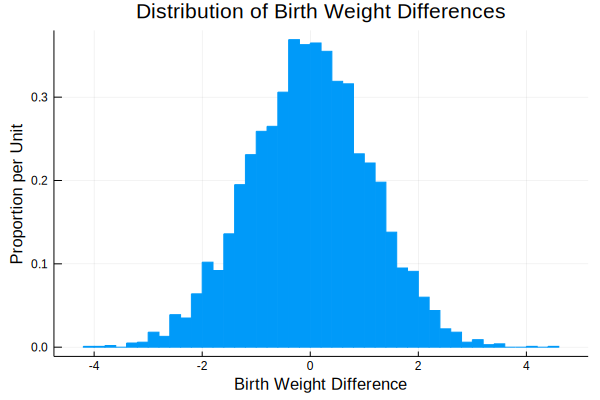

In [64]:
# HIDDEN
histogram(differences, legend=false, normalize=:pdf, linecolor=1)
title!("Distribution of Birth Weight Differences")
xlabel!("Birth Weight Difference")
ylabel!("Proportion per Unit")

It makes intuitive sense that the distribution of differences is centered around 0 since the two groups should have the same average under the null hypothesis.

In order to draw a conclusion for this hypothesis test, we should calculate the p-value. The empirical p-value of the test is the proportion of simulated differences that were equal to or less than the observed difference. 

In [71]:
p_value = count(differences .<= observed_difference) / repetitions

0.0

At the beginning of the hypothesis test we typically choose a p-value **threshold of significance** (commonly denoted as alpha). If our p-value is below our significance threshold, then we reject the null hypothesis. The most commonly chosen thresholds are 0.01 and 0.05, where 0.01 is considered to be more "strict" since we would need more evidence in favor of the alternative hypothesis to reject the null hypothesis.

In either of these two cases, we reject the null hypothesis since the p-value is less than the significance threshold. 

## Bootstrap Confidence Intervals

Data scientists must often estimate an unknown population parameter using a random sample. Although we would ideally like to take numerous samples from the population to generate a sampling distribution, we are often limited to a single sample by money and time.

Fortunately, a large, randomly collected sample looks like the original population. The bootstrap procedure uses this fact to simulate new samples by resampling from the original sample.

To conduct the bootstrap, we perform the following steps:

1. Sample with replacement from the original sample (now the bootstrap population). These samples are called bootstrap samples. We typically take thousands of bootstrap samples (~10,000 is common).
1. Calculate the statistic of interest for each bootstrap sample. This statistic is called the bootstrap statistic, and the empirical distribution of these bootstrap statistics is an approximation to the sampling distribution of the bootstrapped statistic.

![alt text](https://www.inferentialthinking.com/images/chapters/13/2/Bootstrap_25_0.png)

We may use the bootstrap sampling distribution to create a confidence interval which we use to estimate the value of the population parameter. 

Since the birth weight data provides a large, random sample, we may act as if the data on mothers who did not smoke are representative of the population of nonsmoking mothers. Similarly, we act as if the data for smoking mothers are representative of the population of smoking mothers.

Therefore, we treat our original sample as the bootstrap population to perform the bootstrap procedure:

1. Draw a sample with replacement from the nonsmoking mothers and calculate the mean birth weight for these mothers. We also draw a sample with replacement from the smoking mothers and calculate the mean birth weight.
1. Calculate the difference in means.
1. Repeat the above process 10000 times, obtaining 10000 mean differences.

This procedure gives us a empirical sampling distribution of differences in mean baby weights.

In [73]:
function resample(sample)
    return rand(sample, length(sample))
end

function bootstrap(sample, stat, replicates)
    return [stat(resample(sample)) for i in 1:replicates]
end;

In [77]:
nonsmoker = baby[baby.Maternal_Smoker .== false, :Birth_Weight]
smoker = baby[baby.Maternal_Smoker .== true, :Birth_Weight]

nonsmoker_means = bootstrap(nonsmoker, mean, 10000)
smoker_means = bootstrap(smoker, mean, 10000)

mean_differences = smoker_means .- nonsmoker_means;

We plot the empirical distribution of the difference in means below:

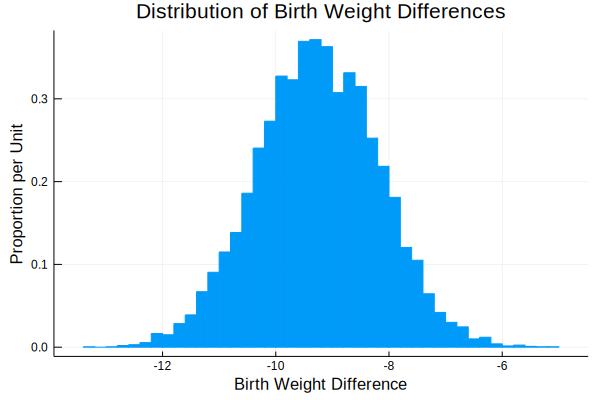

In [78]:
# HIDDEN
histogram(mean_differences, legend=false, normalize=:pdf, linecolor=1)
title!("Distribution of Birth Weight Differences")
xlabel!("Birth Weight Difference")
ylabel!("Proportion per Unit")

Finally, to construct a 95% confidence interval we take the 2.5th and 97.5th percentiles of the bootstrap statistics:

In [79]:
quantile(mean_differences, (0.025, 0.975))

(-11.360837713484766, -7.1857019668784385)

This confidence interval allows us to state with 95% confidence that the population mean difference in birth weights is between -11.37 and -7.18 ounces.

## Summary

In this section, we review hypothesis testing using the permutation test and confidence intervals using the bootstrap. To conduct a hypothesis test, we must state our null and alternative hypotheses, select an appropriate test statistic, and perform the testing procedure to calculate a p-value. To create a confidence interval, we select an appropriate test statistic, bootstrap the original sample to generate an empirical distribution of the test statistic, and select the quantiles corresponding to our desired confidence level.